In [1]:
# on installe la bibliothèque TA-lib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3721    0  3721    0     0   3235      0 --:--:--  0:00:01 --:--:--  3235
100  503k  100  503k    0     0   173k      0  0:00:02  0:00:02 --:--:--  435k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3741    0  3741    0     0  11510      0 --:--:-- --:--:-- --:--:-- 11510
100  406k  100  406k    0     0   195k      0  0:00:02  0:00:02 --:--:--  295k


In [2]:
# On se place dans le drive (os?)
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import talib.abstract as ta
import pandas as pd

import os

## Import de la donnée

In [4]:
datas_path = "/content/drive/My Drive/Colab Notebooks/OC_Rapport_alternance"

symb = 'BTCUSDT'

candles = pd.read_csv(os.path.join(datas_path, symb+'.csv')).drop(['closetime'], axis=1)
candles['opentime'] = pd.to_datetime(candles['opentime'], unit='ms')
candles.set_index('opentime', drop=True, inplace=True)

In [5]:
candles

,open,high,low,close,volume
opentime,,,,,
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
2017-08-22,4016.00,4104.82,3400.00,4040.00,966.684858
...,...,...,...,...,...
2021-08-31,46982.91,48246.11,46700.00,47100.89,48645.527370
2021-09-01,47100.89,49156.00,46512.00,48810.52,49904.655280
2021-09-02,48810.51,50450.13,48584.06,49246.64,54410.770538


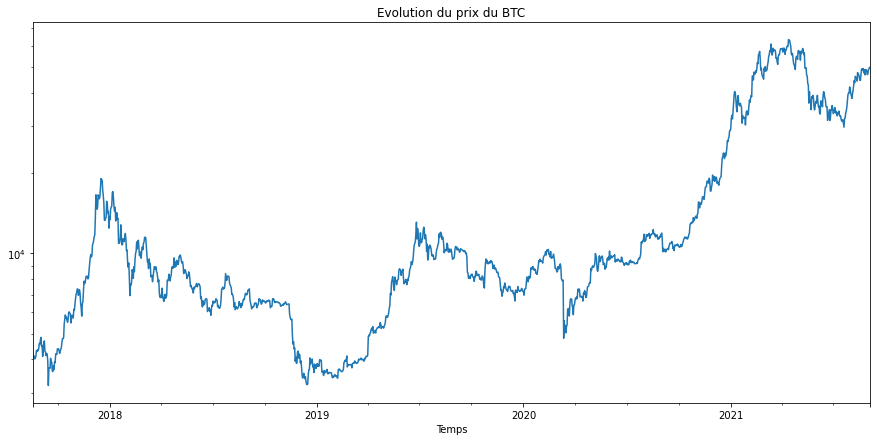

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
candles.close.plot()
plt.yscale('log')
plt.title("Evolution du prix du BTC")
plt.xlabel("Temps")
plt.show()

## Feature engineering

In [7]:
def populate_indicators(df):
    dataframe = df.copy()

    ########################
    ####### ANALYSIS #######
    ########################

    ## RSI ##
    dataframe['rsi3'] = ta.RSI(dataframe, timeperiod=3)
    dataframe['rsi7'] = ta.RSI(dataframe, timeperiod=7)  
    dataframe['rsi14'] = ta.RSI(dataframe, timeperiod=14)    
    dataframe['rsi21'] = ta.RSI(dataframe, timeperiod=21) 

    ## MACD ##
    macd = ta.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
    dataframe['macdhist'] = macd['macdhist']

    ## ATR ##
    dataframe['atr7'] = ta.ATR(dataframe, timeperiod=7)
    dataframe['atr14'] = ta.ATR(dataframe, timeperiod=14)
    dataframe['atr21'] = ta.ATR(dataframe, timeperiod=21)
    
    

    ## BOLLINGER ##
    bollinger = ta.BBANDS(dataframe, timeperiod=20, nbdevup=1., nbdevdn=1., matype=0)
    dataframe['bb1up'] = bollinger['upperband']
    dataframe['bb1mid'] = bollinger['middleband']
    dataframe['bb1low'] = bollinger['lowerband']

    ## MAs ##

    dataframe['ema3'] = ta.EMA(dataframe.close, timeperiod=3)
    dataframe['ema7'] = ta.EMA(dataframe.close, timeperiod=7)
    dataframe['ema14'] = ta.EMA(dataframe.close, timeperiod=14)
    dataframe['ema21'] = ta.EMA(dataframe.close, timeperiod=21)

    return dataframe

df_indics = populate_indicators(candles)

In [8]:
df_indics.tail()

,open,high,low,close,volume,rsi3,rsi7,rsi14,rsi21,macdhist,atr7,atr14,atr21,bb1up,bb1mid,bb1low,ema3,ema7,ema14,ema21
opentime,,,,,,,,,,,,,,,,,,,,
2021-08-31,46982.91,48246.11,46700.00,47100.89,48645.527370,30.325560,45.632323,54.028117,56.250305,-465.418779,2029.399039,2166.783590,2233.839758,49056.302561,47474.2485,45892.194439,47474.150435,47849.803864,47553.856240,46749.722751
2021-09-01,47100.89,49156.00,46512.00,48810.52,49904.655280,66.010397,57.437884,58.936772,59.350381,-398.981537,2117.199176,2200.870476,2253.371198,49133.804934,47694.8245,46255.844066,48142.335217,48089.982898,47721.411408,46937.067956
2021-09-02,48810.51,50450.13,48584.06,49246.64,54410.770538,71.580056,60.021473,60.106960,60.107531,-326.796754,2081.323580,2176.956157,2234.928284,49245.427871,47767.1565,46288.885129,48694.487609,48379.147173,47924.775220,47147.029051
2021-09-03,49246.63,51000.00,48316.84,49999.14,59025.644157,80.043657,64.374652,62.113169,61.409774,-233.858102,2167.300211,2213.113574,2256.272651,49459.164281,47913.6880,46368.211719,49346.813804,48784.145380,48201.357191,47406.311864
2021-09-04,49998.00,50535.69,49370.00,49915.64,34664.659590,76.263416,63.479818,61.742125,61.177094,-185.601881,2024.213038,2138.297604,2204.340144,49649.200912,48060.7790,46472.357088,49631.226902,49067.019035,48429.928232,47634.432604


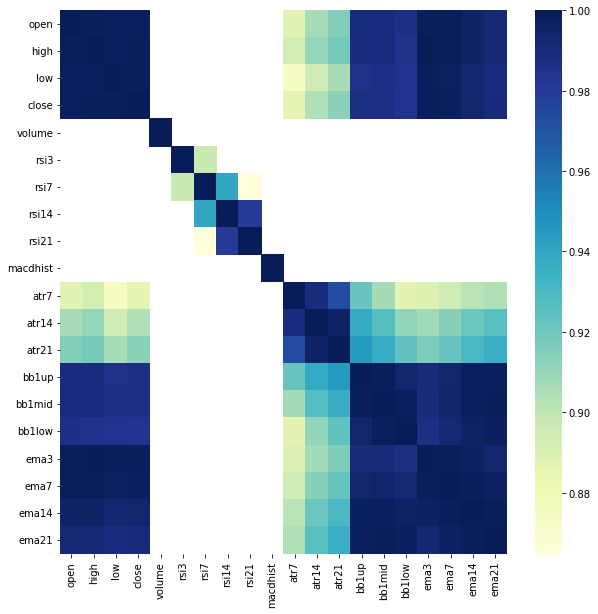

In [9]:
import seaborn
import numpy as np

c = df_indics.corr()
plt.figure(figsize=(10,10))
seaborn.heatmap(c, cmap="YlGnBu", mask = (np.abs(c) <= 0.8))
plt.show()

On observe de forte corrélation entre de nombreux paramètres.
On sélectionne les paramètres les plus représentatifs.

In [10]:
df_final = df_indics.loc[:, ['close', 'volume', 'rsi14', 'macdhist', 'atr14']]
df_final['target'] = df_final.close.shift(-5)
df_final.dropna(inplace=True)

In [11]:
df_final.tail()

,close,volume,rsi14,macdhist,atr14,target
opentime,,,,,,
2021-08-26,46843.87,49371.277774,55.865070,-256.097221,2321.870893,47100.89
2021-08-27,49069.90,42068.104965,61.325405,-229.495444,2356.160829,48810.52
2021-08-28,48895.35,26681.063786,60.691335,-234.105222,2255.872199,49246.64
2021-08-29,48767.83,32652.283473,60.201615,-254.501228,2228.290613,49999.14
2021-08-30,46982.91,40288.350830,53.673253,-388.913881,2214.527712,49915.64


In [50]:
X_train = df_final.head(int(len(candles)*0.7)).drop(['target'], axis=1)
y_train = df_final.head(int(len(candles)*0.7))['target']

X_test = df_final.tail(len(df_final)-len(X_train)).drop(['target'], axis=1)
y_test = df_final.tail(len(df_final)-len(X_train))['target']

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1035, 5), (1035,), (406, 5), (406,))

## Scaling

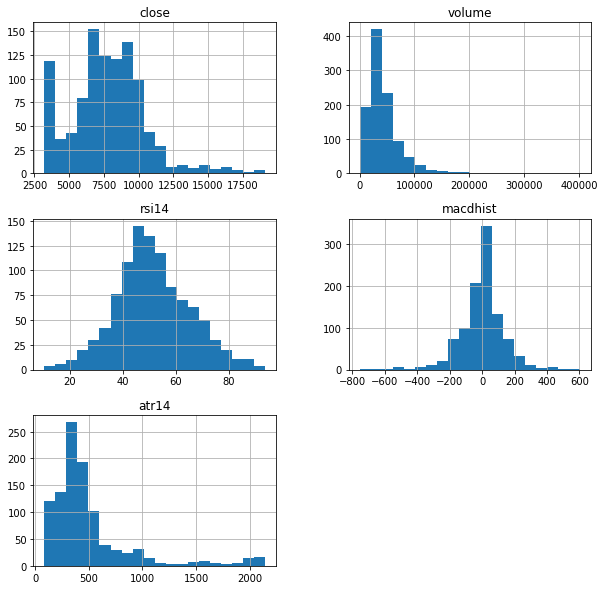

In [52]:
X_train.hist(bins=20, figsize=(10, 10))
plt.show()

In [15]:
def normalize(X, y, length):
  X_norm = (X - X.rolling(length).mean())/X.rolling(length).std()
  X_norm.dropna(inplace=True)
  y_norm = (y - X['close'].rolling(length).mean())/X['close'].rolling(length).std()
  y_norm = y_norm[X_norm.index]
  return X_norm, y_norm

In [16]:
X_train_norm, y_train_norm = normalize(X_train, y_train, 14)
X_test_norm, y_test_norm = normalize(X_test, y_test, 14)

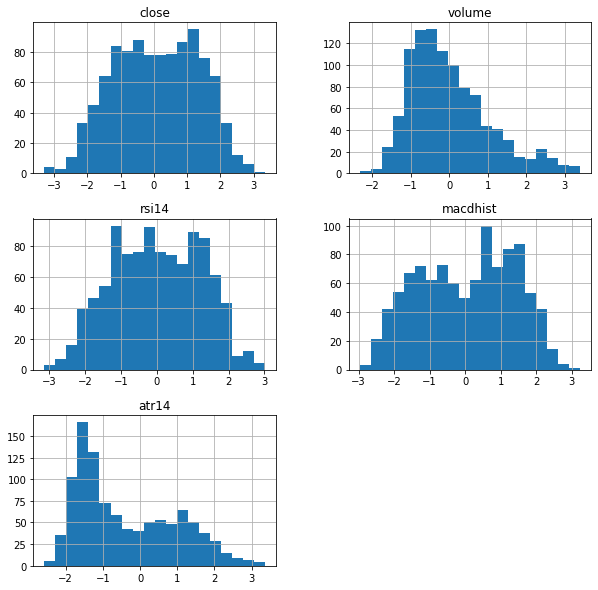

In [48]:
X_train_norm.hist(bins=20, figsize=(10, 10))
plt.show()

## Regression

Coefficients: 
 [ 1.38140511  0.05333976 -0.0451596  -0.17749694 -0.04652443]
Mean squared error: 4.70
Variance score: 0.28


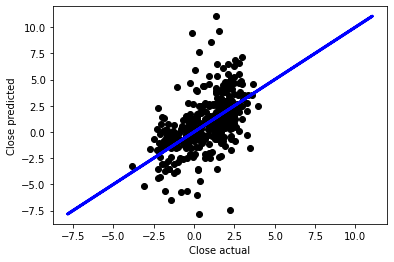

In [17]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(X_train_norm, y_train_norm)
y_pred = regr.predict(X_test_norm)

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_test_norm, y_pred))
print('Variance score: %.2f' % r2_score(y_test_norm, y_pred))

plt.scatter(y_pred, y_test_norm,  color='black')
plt.plot(y_test_norm, y_test_norm, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')

plt.show()

ValueError: ignored

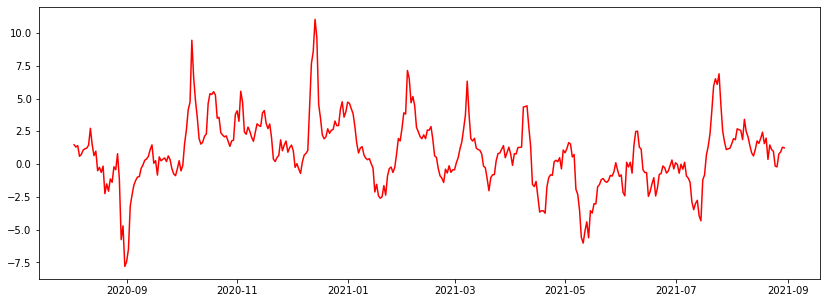

In [45]:
plt.figure(figsize=(14,5))
plt.plot(y_test_norm, color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_test_norm.index, y_pred[y_test_norm.index], color = 'green', label = 'Predicted Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price scaled')
plt.legend()

Mean squared error: 12999838.90
Variance score: 0.95


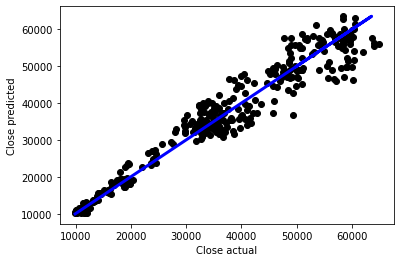

In [19]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
regr.fit(X_train_norm, y_train_norm)
y_pred_norm = regr.predict(X_test_norm)

y_pred = y_pred_norm * X_test['close'].rolling(14).std()[y_test_norm.index] + X_test['close'].rolling(14).mean()[y_test_norm.index]



print("Mean squared error: %.2f"
      % mean_squared_error(y_test[y_test_norm.index], y_pred))
print('Variance score: %.2f' % r2_score(y_test[y_test_norm.index], y_pred))

plt.scatter(y_pred, y_test[y_test_norm.index],  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')
plt.show()

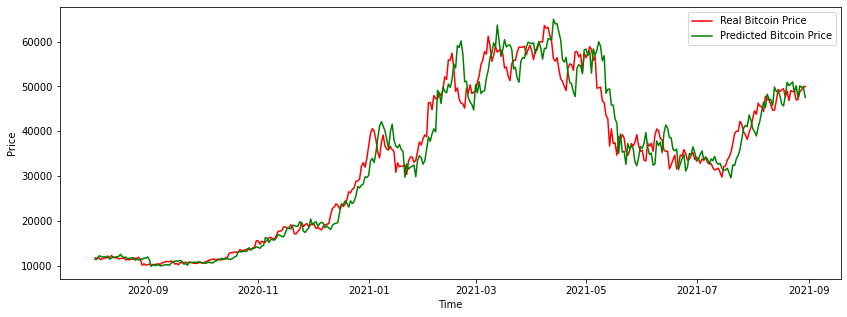

In [20]:
plt.figure(figsize=(14,5))
plt.plot(y_test[y_test_norm.index], color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_test_norm.index, y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

## K-NeighborsResgressor

Mean squared error: 5.99
Variance score: -214847955.93


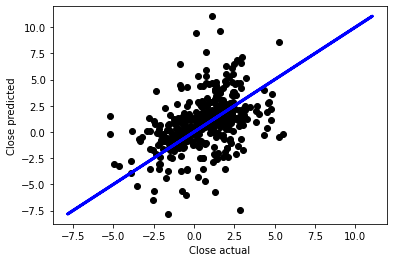

In [21]:
from sklearn import neighbors
n_neighbors = 5

model = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)


print("Mean squared error: %.2f"
      % mean_squared_error(y_test_norm, y_pred_norm))
print('Variance score: %.2f' % r2_score(y_test_norm, y_pred))

plt.scatter(y_pred_norm, y_test_norm,  color='black')
plt.plot(y_test_norm, y_test_norm, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')
plt.show()

y_knn = y_pred.copy()

Mean squared error: 19461438.32
Variance score: 0.93


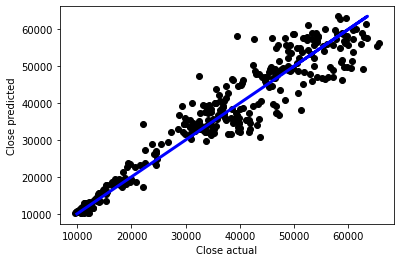

In [22]:
model = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

y_pred = y_pred_norm * X_test['close'].rolling(14).std()[y_test_norm.index] + X_test['close'].rolling(14).mean()[y_test_norm.index]



print("Mean squared error: %.2f"
      % mean_squared_error(y_test[y_test_norm.index], y_pred))
print('Variance score: %.2f' % r2_score(y_test[y_test_norm.index], y_pred))

plt.scatter(y_pred, y_test[y_test_norm.index],  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')
plt.show()

## SVR

Mean squared error: 6.29
Variance score: -212937344.09


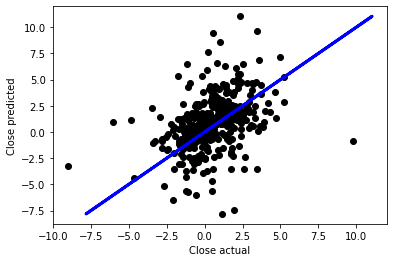

In [23]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1e3, gamma=0.1)

model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test_norm, y_pred_norm))
print('Variance score: %.2f' % r2_score(y_test_norm, y_pred))

plt.scatter(y_pred_norm, y_test_norm,  color='black')
plt.plot(y_test_norm, y_test_norm, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')
plt.show()

Mean squared error: 24025391.83
Variance score: 0.91


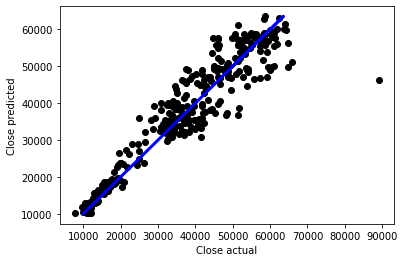

In [24]:
model = SVR(kernel='rbf', C=1e3, gamma=0.1)

model.fit(X_train_norm, y_train_norm)
y_pred_norm = model.predict(X_test_norm)

y_pred = y_pred_norm * X_test['close'].rolling(14).std()[y_test_norm.index] + X_test['close'].rolling(14).mean()[y_test_norm.index]



print("Mean squared error: %.2f"
      % mean_squared_error(y_test[y_test_norm.index], y_pred))
print('Variance score: %.2f' % r2_score(y_test[y_test_norm.index], y_pred))

plt.scatter(y_pred, y_test[y_test_norm.index],  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')
plt.show()

## Réseau convolutionnel

On sépare les trains/test sets

In [25]:
df_final

,close,volume,rsi14,macdhist,atr14,target
opentime,,,,,,
2017-09-20,3900.00,720.935076,46.871557,-36.312066,410.280349,3920.75
2017-09-21,3609.99,1001.654084,41.535315,-44.225005,405.474610,3882.35
2017-09-22,3595.87,838.966425,41.288844,-46.901478,393.972852,4193.00
2017-09-23,3780.00,752.792791,45.805121,-33.396782,385.423363,4174.50
2017-09-24,3660.02,661.636390,43.459214,-29.789453,369.838123,4174.69
...,...,...,...,...,...,...
2021-08-26,46843.87,49371.277774,55.865070,-256.097221,2321.870893,47100.89
2021-08-27,49069.90,42068.104965,61.325405,-229.495444,2356.160829,48810.52
2021-08-28,48895.35,26681.063786,60.691335,-234.105222,2255.872199,49246.64


In [26]:
from sklearn.preprocessing import MinMaxScaler 

train_data = df_final.head(int(len(candles)*0.8)).drop(['target'], axis=1)
test_data = df_final.tail(len(candles)-len(train_data)).drop(['target'], axis=1)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
train_data

X_train = [] 
y_train = []

days_inputs = 21
shift_output = 0

for i in range(days_inputs, train_data.shape[0]-shift_output):
  X_train.append(train_data[i-days_inputs:i])
  y_train.append(train_data[i+shift_output,0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 21, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 21, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [28]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [29]:
history= model.fit(X_train, y_train, epochs = 20, batch_size =20, validation_split=0.1)


Epoch 1/20
53/53 [==============================] - 10s 84ms/step - loss: 0.0255 - accuracy: 9.5694e-04 - val_loss: 0.0772 - val_accuracy: 0.0085
Epoch 2/20
53/53 [==============================] - 4s 69ms/step - loss: 0.0104 - accuracy: 9.5694e-04 - val_loss: 0.0204 - val_accuracy: 0.0085
Epoch 3/20
53/53 [==============================] - 4s 71ms/step - loss: 0.0085 - accuracy: 9.5694e-04 - val_loss: 0.0483 - val_accuracy: 0.0085
Epoch 4/20
53/53 [==============================] - 4s 69ms/step - loss: 0.0073 - accuracy: 9.5694e-04 - val_loss: 0.0180 - val_accuracy: 0.0085
Epoch 5/20
53/53 [==============================] - 4s 68ms/step - loss: 0.0077 - accuracy: 9.5694e-04 - val_loss: 0.0290 - val_accuracy: 0.0085
Epoch 6/20
53/53 [==============================] - 4s 69ms/step - loss: 0.0062 - accuracy: 9.5694e-04 - val_loss: 0.0237 - val_accuracy: 0.0085
Epoch 7/20
53/53 [==============================] - 4s 71ms/step - loss: 0.0052 - accuracy: 9.5694e-04 - val_loss: 0.0433 - val_a

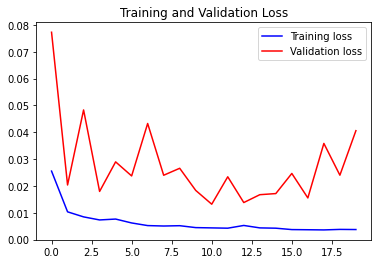

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

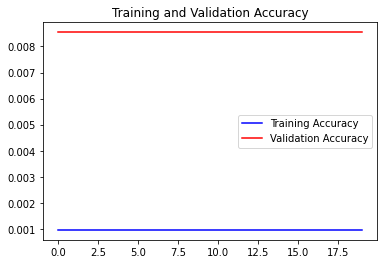

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [32]:
part_60_days = df_final.head(int(len(df_final)*0.7)).tail(60).drop(['target'], axis=1)
df= part_60_days.append(df_final.drop(['target'], axis=1).tail(len(df_final)-len(train_data)), ignore_index = True)
df.head()

,close,volume,rsi14,macdhist,atr14
0,7538.67,43874.427726,59.903256,66.159090,398.574893
1,7693.10,50522.616209,62.255185,77.342876,385.819543
2,7774.62,65441.339576,63.473177,84.693407,371.548147
3,7738.98,46302.752638,62.523257,81.586090,353.643280
4,8778.57,183546.887514,74.507639,140.519604,417.157331


In [33]:
inputs = scaler.transform(df) 
inputs

array([[0.26249154, 0.10842595, 0.59551361, 0.60342097, 0.15194063],
       [0.27185994, 0.12496768, 0.62386282, 0.61164792, 0.14573491],
       [0.27680529, 0.16208779, 0.638544  , 0.61705508, 0.1387916 ],
       ...,
       [2.77136704, 0.06564618, 0.6050128 , 0.38254235, 1.05555129],
       [2.76363112, 0.0805035 , 0.59910991, 0.36753877, 1.04213232],
       [2.65535014, 0.09950323, 0.52041965, 0.26866294, 1.03543641]])

In [34]:
X_test = []
y_test = []
for i in range (days_inputs, inputs.shape[0]-shift_output):
      X_test.append(inputs[i-days_inputs:i]) 
      y_test.append(inputs[i+shift_output, 0])


X_test, y_test = np.array(X_test), np.array(y_test) 

In [35]:
X_test.shape, y_test.shape
y_pred = model.predict(X_test) 

In [36]:
y_pred[:10]

array([[0.30139798],
       [0.29844862],
       [0.29757023],
       [0.298839  ],
       [0.3022816 ],
       [0.3069882 ],
       [0.31090027],
       [0.31381336],
       [0.31559986],
       [0.31538442]], dtype=float32)

In [37]:
y_test[:10]

array([0.37427165, 0.39239633, 0.39566553, 0.39818917, 0.38216772,
       0.35530676, 0.36145509, 0.36201017, 0.33417677, 0.34509696])

In [38]:
scaler.scale_


array([6.06643351e-05, 2.48815590e-06, 1.20535994e-02, 7.35613969e-04,
       4.86519124e-04])

In [39]:
scale = 1/6.06643351e-05
y_test = y_test*scale 
y_pred = y_pred*scale
y_pred[:10]

array([[4968.2896],
       [4919.672 ],
       [4905.1924],
       [4926.107 ],
       [4982.855 ],
       [5060.44  ],
       [5124.927 ],
       [5172.947 ],
       [5202.3955],
       [5198.844 ]], dtype=float32)

In [40]:
y_test[:10]

array([6169.55000346, 6468.32000363, 6522.21000366, 6563.81000368,
       6299.71000354, 5856.93000329, 5958.28000334, 5967.43000335,
       5508.62000309, 5688.63000319])

Mean squared error: 526489019.30
Variance score: -1.36


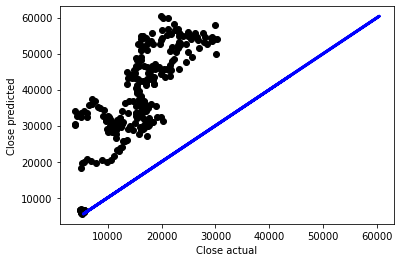

In [41]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

plt.scatter(y_pred, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)

plt.xlabel('Close actual')
plt.ylabel('Close predicted')
plt.show()

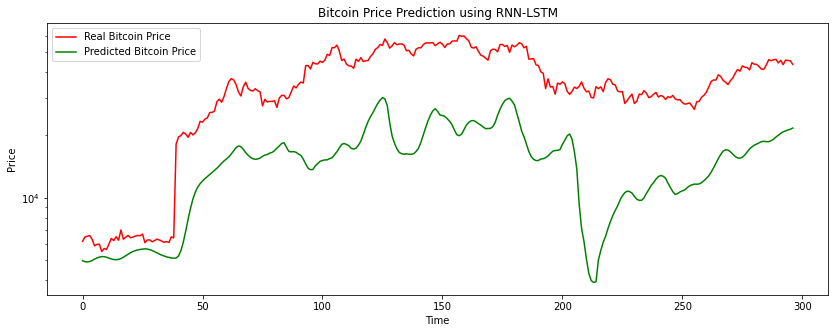

In [42]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.yscale('log')
plt.legend()
plt.show()

In [43]:
def compute_stats(candles, days_inputs, shift_output):

  train_data = candles.head(int(len(candles)*0.8))
  test_data = candles.tail(len(candles)-len(train_data))

  scaler = MinMaxScaler()
  train_data = scaler.fit_transform(train_data)
  train_data

  X_train = [] 
  Y_train = []

  for i in range(days_inputs, train_data.shape[0]-shift_output):
    X_train.append(train_data[i-days_inputs:i])
    Y_train.append(train_data[i+shift_output,0])

  X_train, Y_train = np.array(X_train), np.array(Y_train)

  model = Sequential() 
  model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
  model.add(Dropout(0.2)) 
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.3)) 
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.4)) 
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(units =1))

  model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
  history= model.fit(X_train, Y_train, epochs = 20, batch_size =50, validation_split=0.1, verbose=0)

  plt.figure(figsize=(14,5))

  ax1 = plt.subplot(121)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  ax1.plot(epochs, loss, 'b', label='Training loss')
  ax1.plot(epochs, val_loss, 'r', label='Validation loss')
  ax1.set_title("Training and Validation Loss")
  ax1.legend()


  ax2 = plt.subplot(122)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(loss))
  ax2.plot(epochs, acc, 'b', label='Training Accuracy')
  ax2.plot(epochs, val_acc, 'r', label='Validation Accuracy')
  ax2.set_title("Training and Validation Accuracy")
  ax2.legend()

  plt.show()

  part_days = candles.head(int(len(candles)*0.7)).tail(days_inputs)
  df= part_days.append(candles.tail(len(candles)-len(train_data)), ignore_index = True)

  inputs = scaler.transform(df) 

  X_test = []
  Y_test = []
  for i in range (days_inputs, inputs.shape[0]-shift_output):
      X_test.append(inputs[i-days_inputs:i]) 
      Y_test.append(inputs[i+shift_output, 0])


  X_test, Y_test = np.array(X_test), np.array(Y_test)

  Y_pred = model.predict(X_test) 

  scale = 1/scaler.scale_[3]
  Y_test = Y_test*scale 
  Y_pred = Y_pred*scale

  print("Mean squared error: %.2f"
        % mean_squared_error(Y_test, Y_pred))
  print('Variance score: %.2f' % r2_score(Y_test, Y_pred))

  plt.figure(figsize=(14,5))
  plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
  plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
  plt.title('Bitcoin Price Prediction using RNN-LSTM')
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.yscale('log')
  plt.legend()
  plt.show()

  return

Nombre de jours utilisés en entrée : 3
Prédiction du jour  : +1


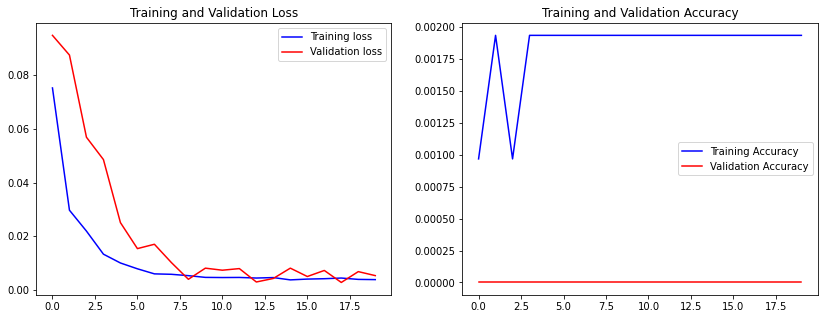

Mean squared error: 972200.04
Variance score: 0.14


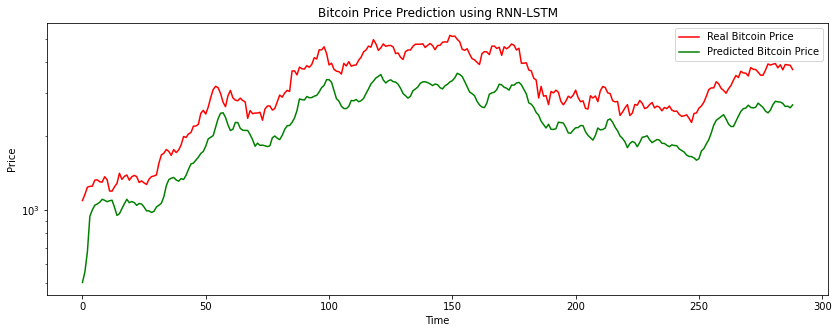

Nombre de jours utilisés en entrée : 7
Prédiction du jour  : +1


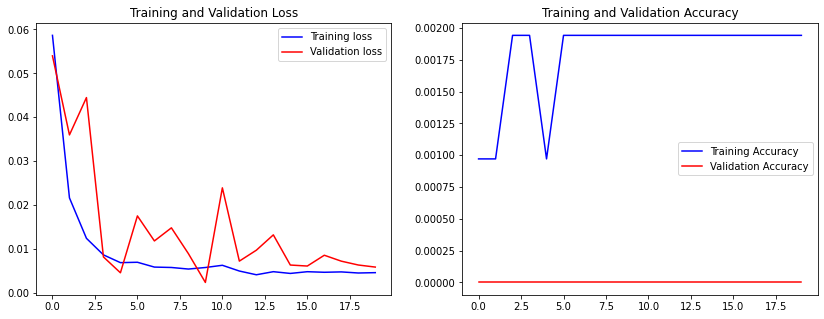

Mean squared error: 581915.71
Variance score: 0.49


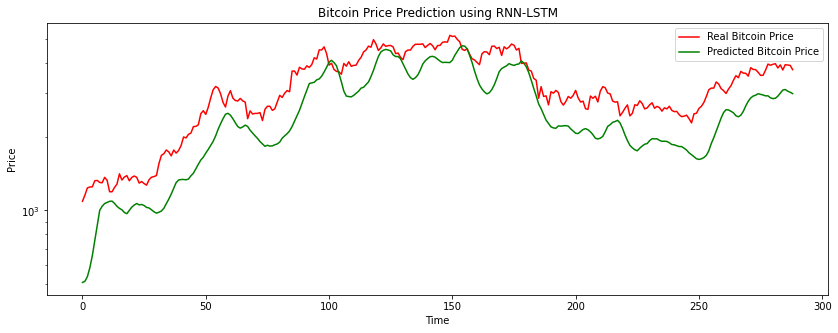

Nombre de jours utilisés en entrée : 21
Prédiction du jour  : +1


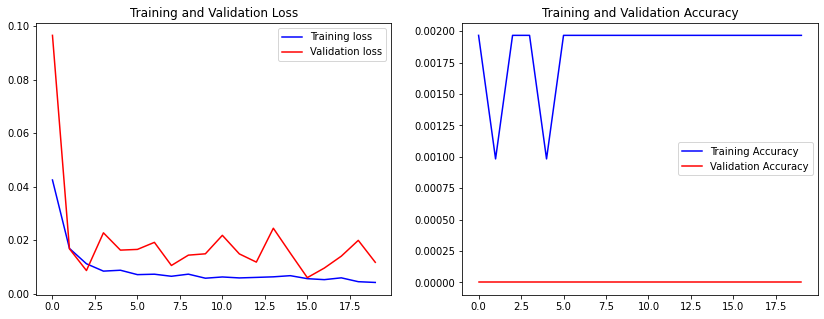

Mean squared error: 3317585.76
Variance score: -1.93


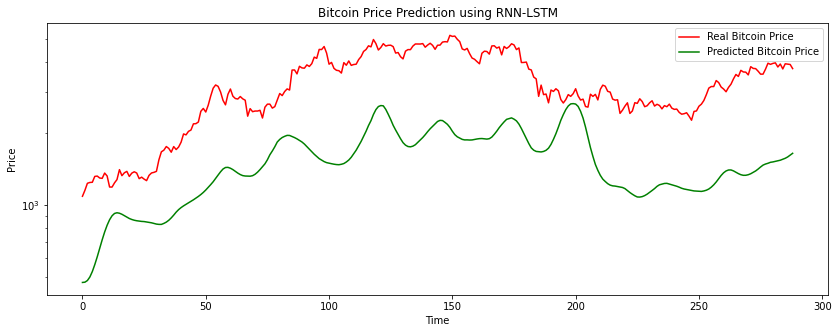

Nombre de jours utilisés en entrée : 60
Prédiction du jour  : +1


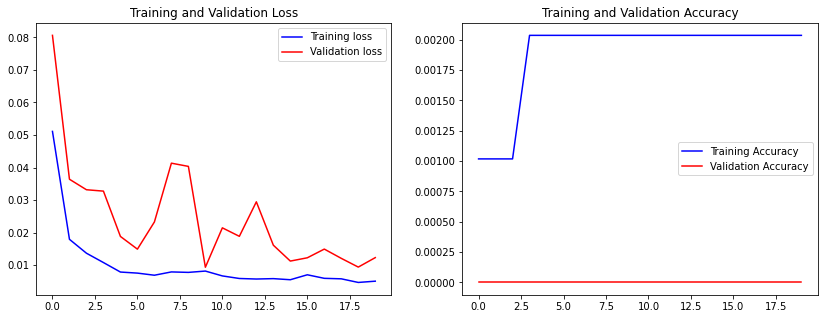

Mean squared error: 3482519.28
Variance score: -2.08


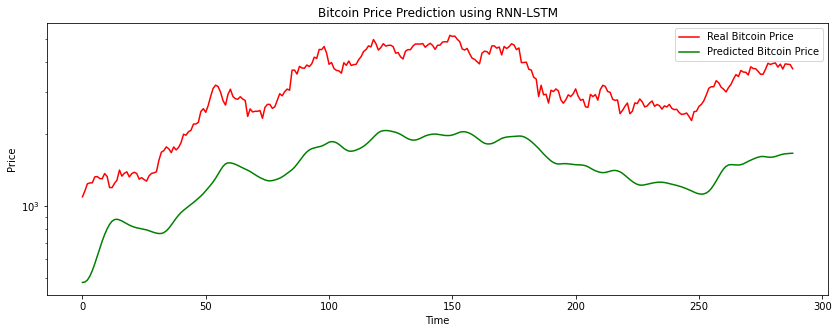

Nombre de jours utilisés en entrée : 3
Prédiction du jour  : +4


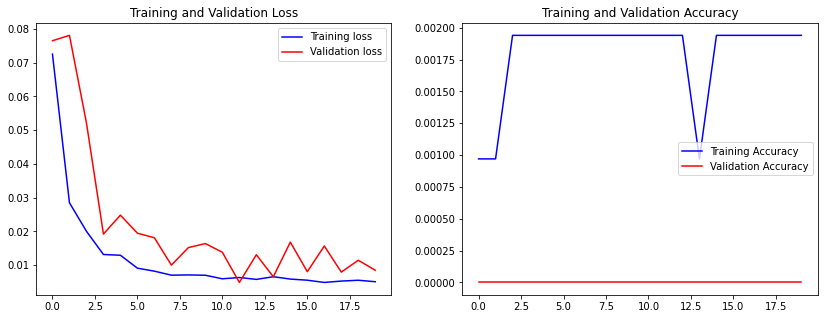

Mean squared error: 790381.86
Variance score: 0.28


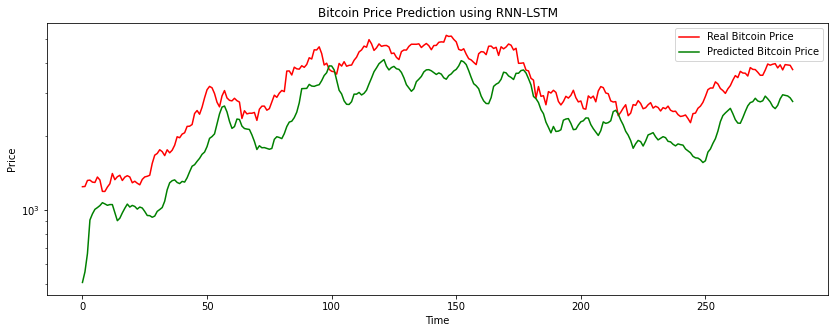

Nombre de jours utilisés en entrée : 7
Prédiction du jour  : +4


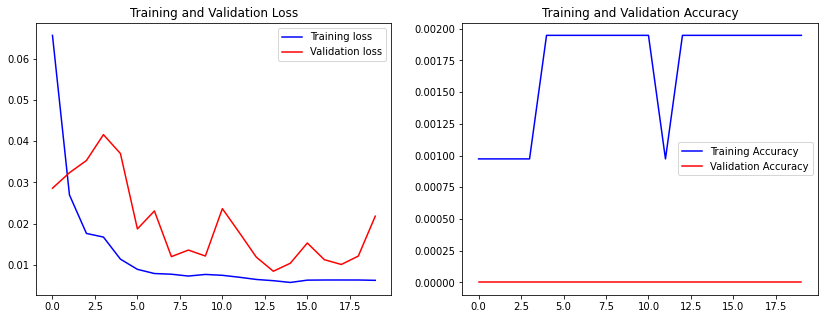

Mean squared error: 1133693.73
Variance score: -0.03


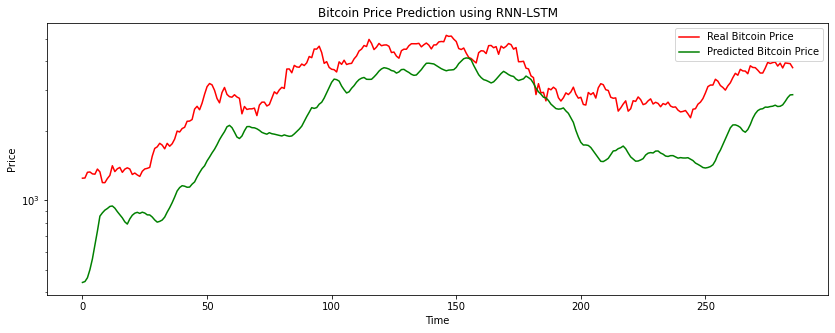

Nombre de jours utilisés en entrée : 21
Prédiction du jour  : +4


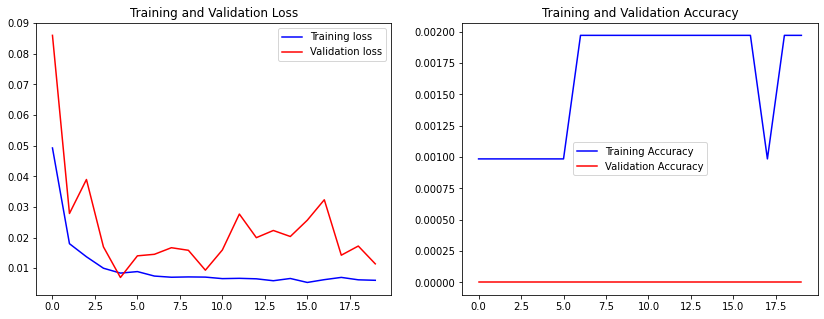

Mean squared error: 6782720.01
Variance score: -5.17


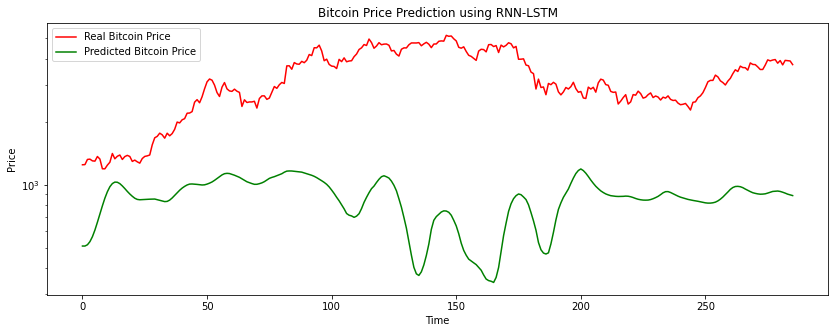

Nombre de jours utilisés en entrée : 60
Prédiction du jour  : +4


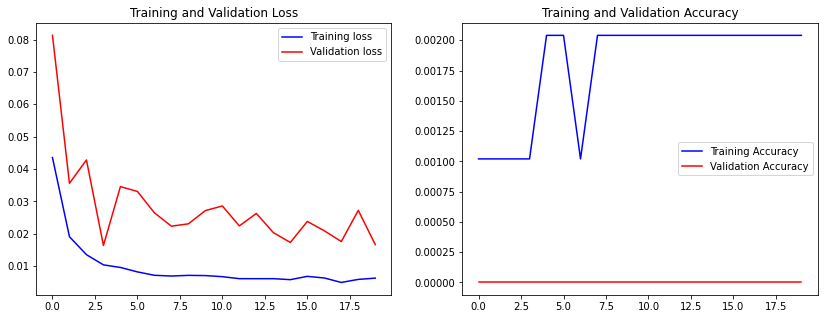

Mean squared error: 8949879843370.10
Variance score: -8137480.12


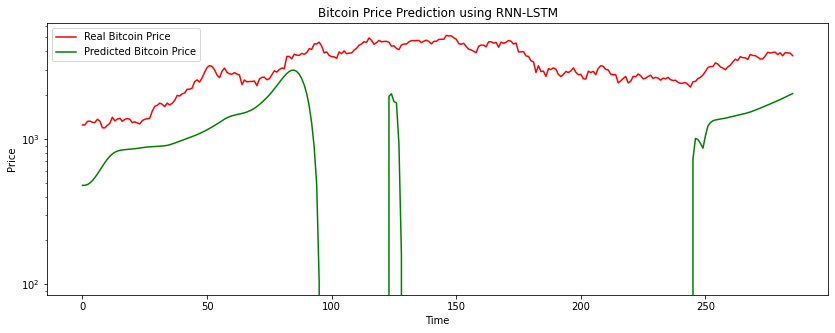

Nombre de jours utilisés en entrée : 3
Prédiction du jour  : +8


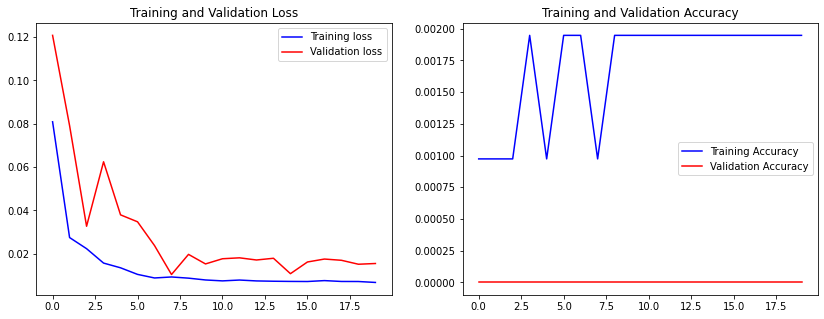

Mean squared error: 606188.85
Variance score: 0.43


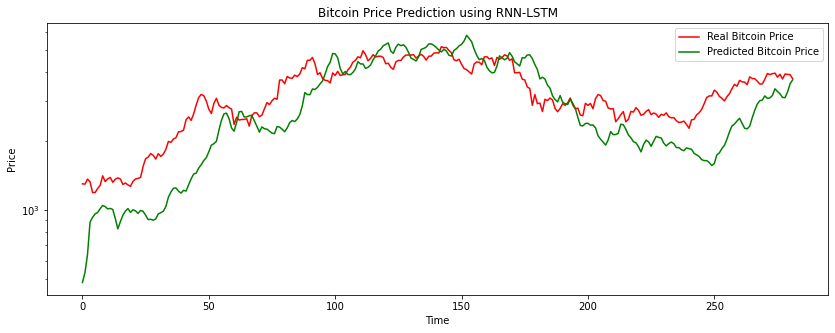

Nombre de jours utilisés en entrée : 7
Prédiction du jour  : +8


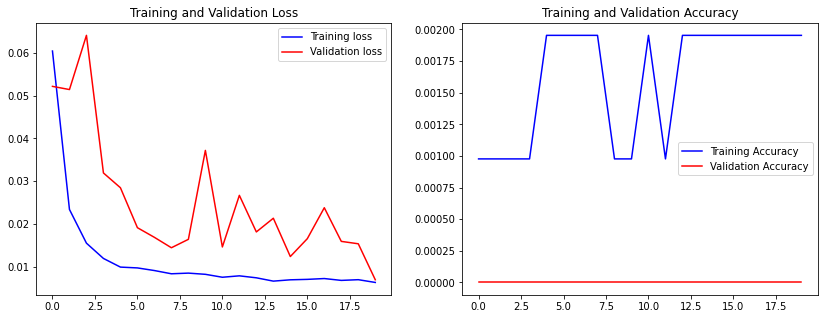

Mean squared error: 2242775.11
Variance score: -1.11


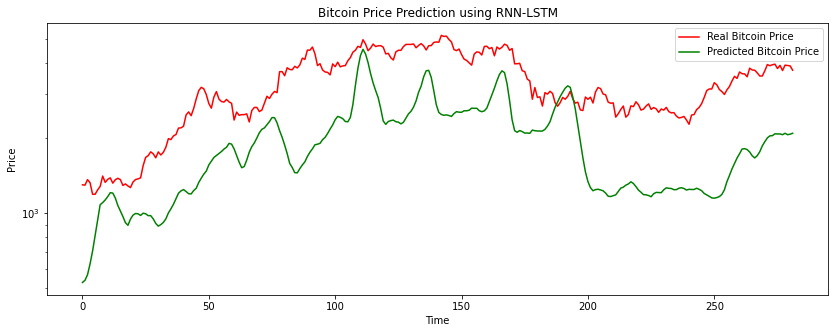

Nombre de jours utilisés en entrée : 21
Prédiction du jour  : +8


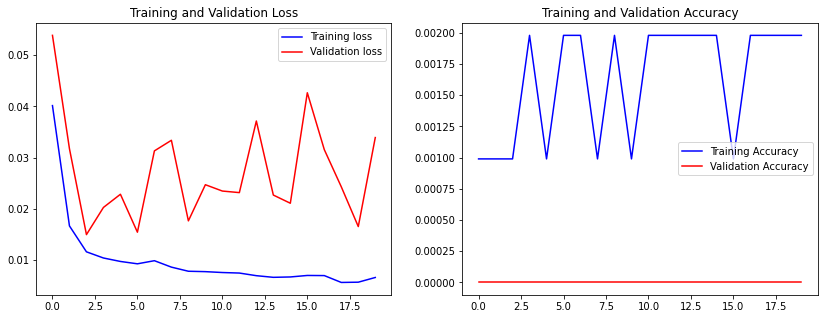

Mean squared error: 7971673.36
Variance score: -6.51


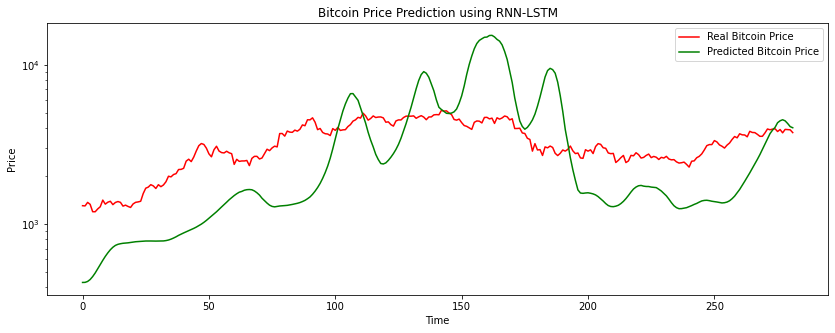

Nombre de jours utilisés en entrée : 60
Prédiction du jour  : +8


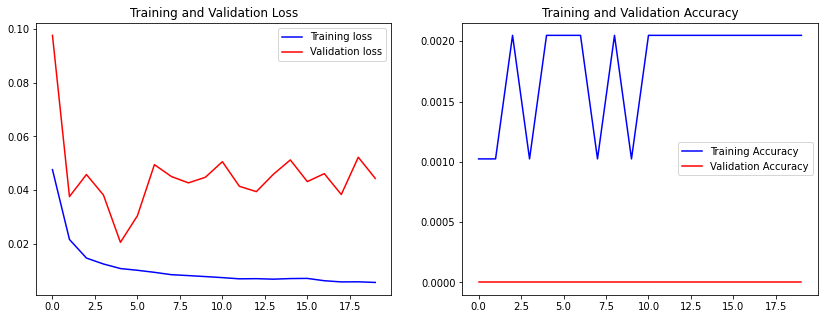

Mean squared error: 50352217348.23
Variance score: -47408.05


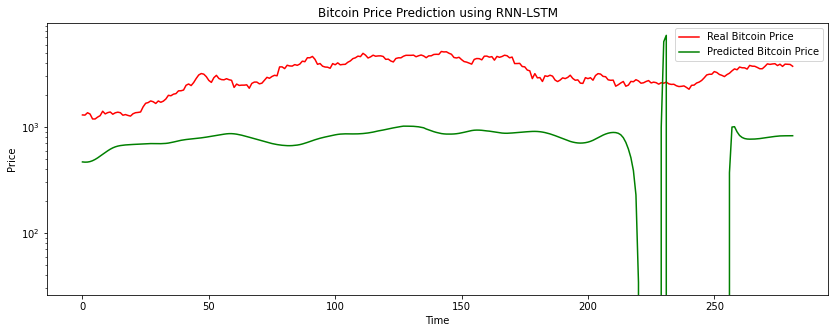

Nombre de jours utilisés en entrée : 3
Prédiction du jour  : +22


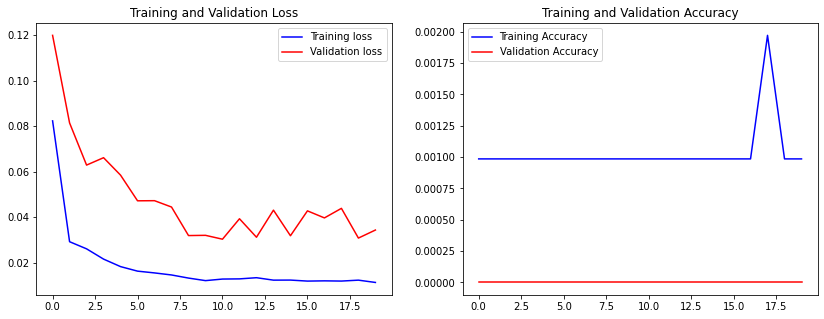

Mean squared error: 4753421.88
Variance score: -4.20


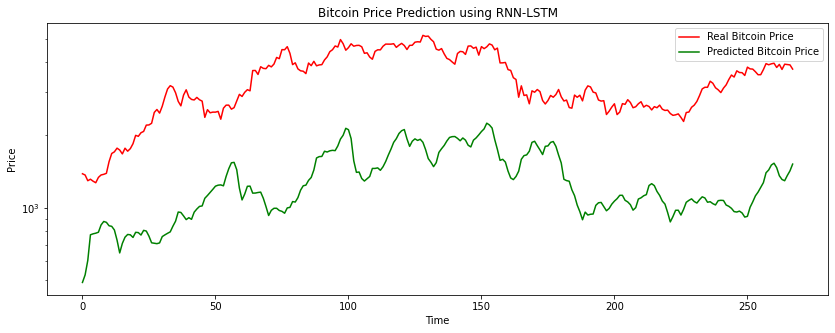

Nombre de jours utilisés en entrée : 7
Prédiction du jour  : +22


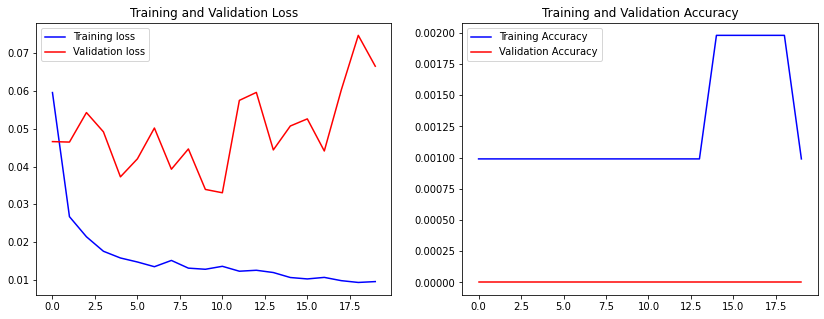

Mean squared error: 8067275.18
Variance score: -7.83


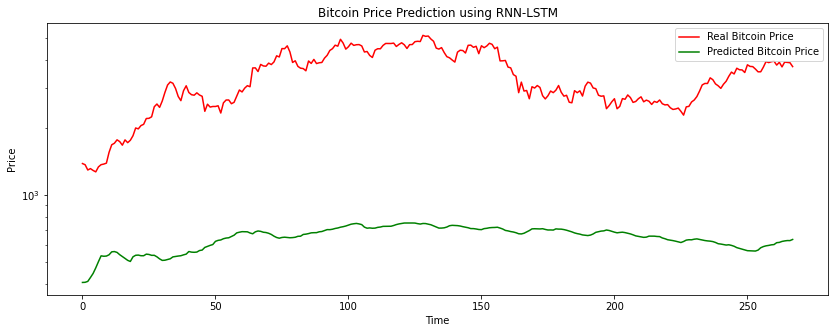

Nombre de jours utilisés en entrée : 21
Prédiction du jour  : +22


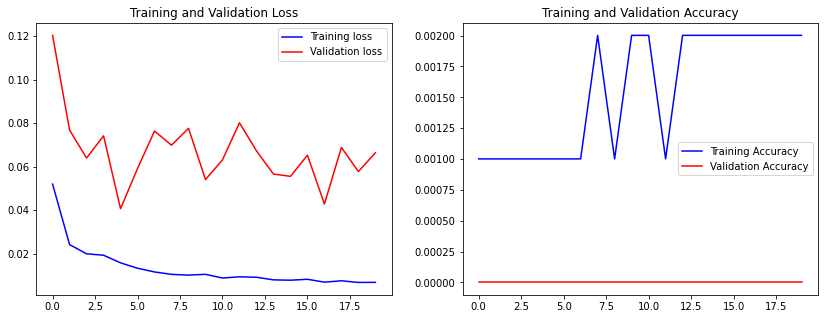

Mean squared error: 6476198.84
Variance score: -6.09


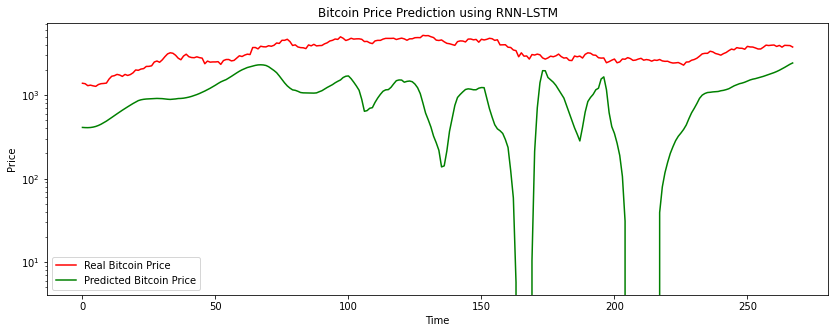

Nombre de jours utilisés en entrée : 60
Prédiction du jour  : +22


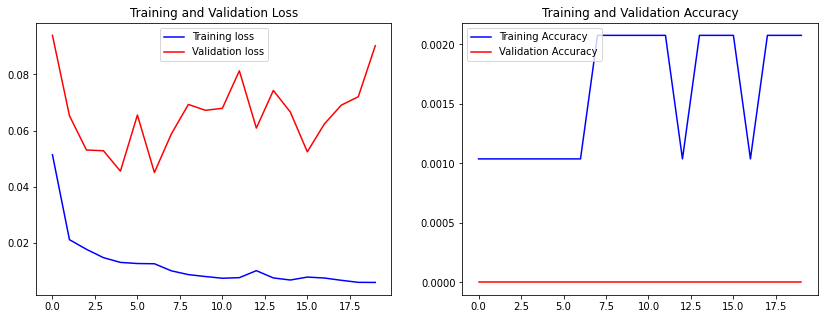

Mean squared error: 33661745465.62
Variance score: -36846.90


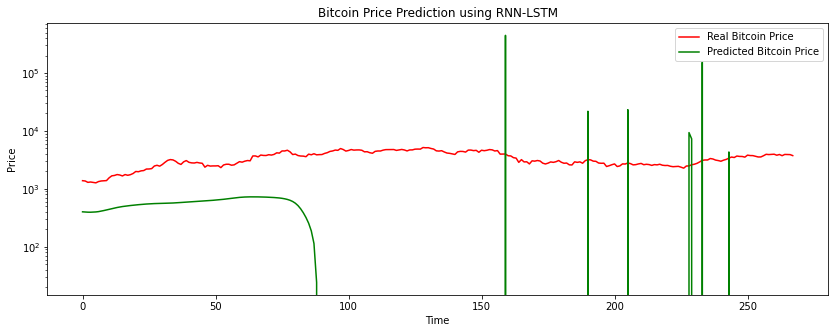

Nombre de jours utilisés en entrée : 3
Prédiction du jour  : +61


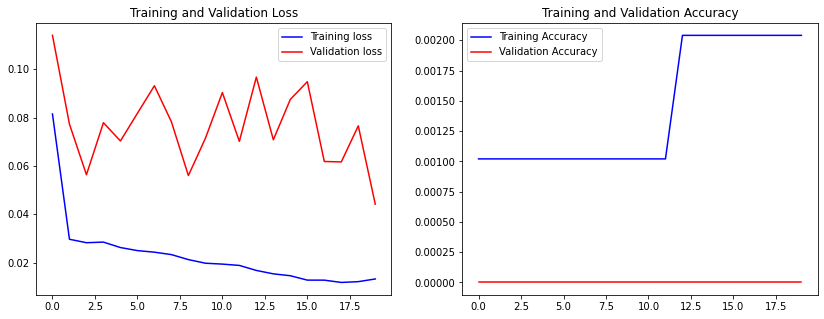

Mean squared error: 8106275.56
Variance score: -11.21


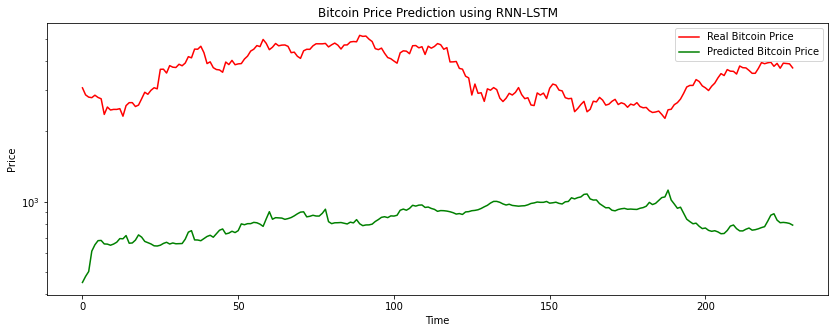

Nombre de jours utilisés en entrée : 7
Prédiction du jour  : +61


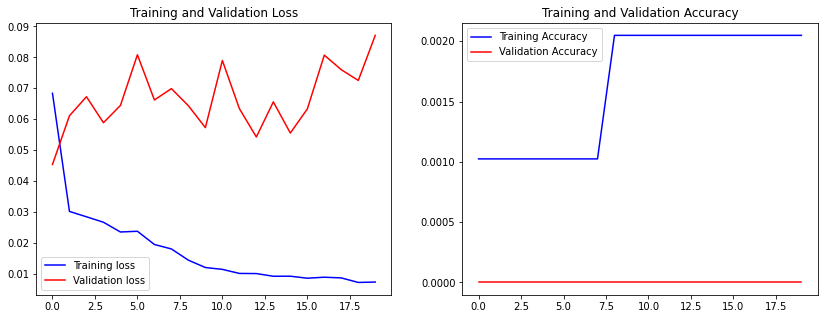

Mean squared error: 6534633.20
Variance score: -8.84


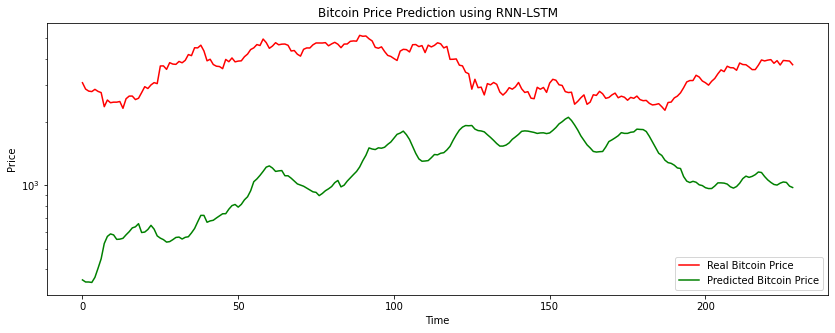

Nombre de jours utilisés en entrée : 21
Prédiction du jour  : +61


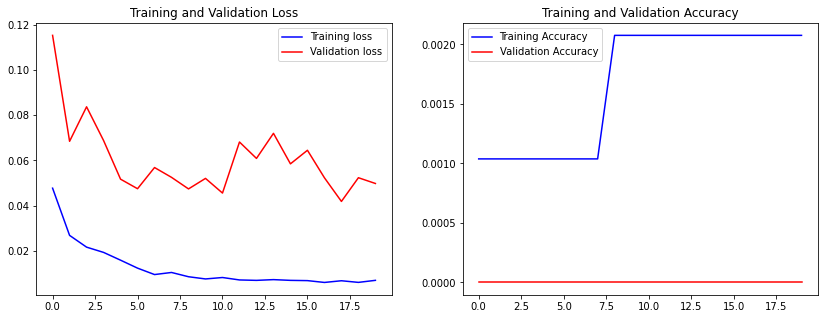

Mean squared error: 423619488.90
Variance score: -637.18


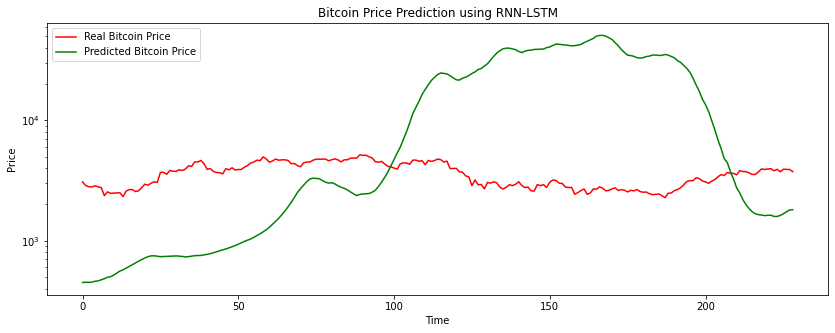

Nombre de jours utilisés en entrée : 60
Prédiction du jour  : +61


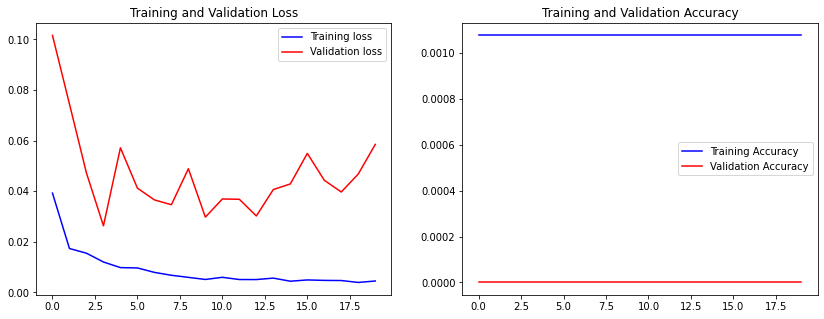

Mean squared error: 28803121316.73
Variance score: -43390.86


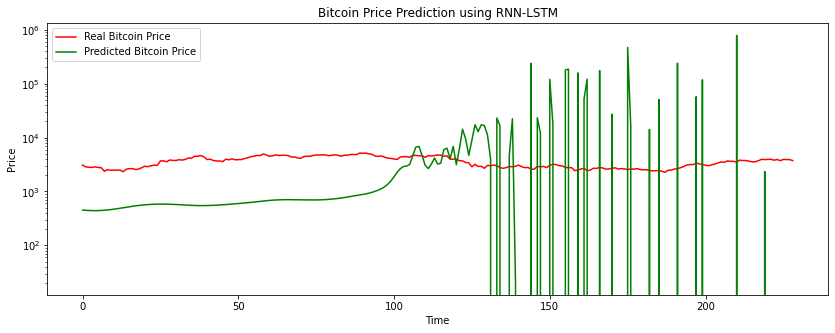

In [44]:
for shift in [0, 3, 7, 21, 60]: 
  for days in [3, 7, 21, 60]:
  
    print('Nombre de jours utilisés en entrée :', days)
    print('Prédiction du jour  :', '+'+str(shift+1))
    compute_stats(candles=df_final.drop(['target'], axis=1), days_inputs=days, shift_output=shift)